# Data-Driven Dynamic Security Assessment with XGBoost

In this example, we will train a XGBoost classifier to classify power system operating points as feasible, stable and secure. Next, using the SHAP toolbox, we will analyze why the operating is point is classified as it is, and which features contributed to classifying an operating point as it is classified.

The input to the classifier is the operating condition, consisting of active power demand, bus voltage magnitudes and generator active power setpoints. The classifier is a multi-class classifier outputting three different classes; feasible, stable and secure. An operating point is

- feasible if it satisfies the operational constraints
- stable if it's lowest dampened mode has a damping ratio of more than 3%
- secure if it's both feasible and stable.

First, we need to load and prepare the dataset which we will use to train the classifier. 

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# python 3.11.11

# Get the parent directory (one level up from python_based)
parent_dir = os.path.abspath(os.path.join(os.getcwd()))

# Append the "data" folder to sys.path
data_path = os.path.join(parent_dir, "data")
sys.path.append(data_path)

# Append the "functions" folder to sys.path
functions_path = os.path.join(parent_dir, "functions")
sys.path.append(functions_path)

from classification_support import fpr_score, StabilityDataset

# load the dataset
dataset = StabilityDataset(data_path, case_size="39", method_type="SD13")

X_method = dataset.X_method
X_train = dataset.X_train
X_test = dataset.X_test
y_train = dataset.y_train
y_test = dataset.y_test
damping_data_method_train = dataset.damping_data_method_train
damping_data_method_test = dataset.damping_data_method_test
op_data_method_train = dataset.op_data_method_train
op_data_method_test = dataset.op_data_method_test

print(X_train.shape)



Method Secure: 4923
Method Insecure: 5077
Method Stable: 9131
Method Instable: 869
Method HIC: 8528
Method Feasible: 5379
Method Infeasible: 4621
(7500, 184)


## Training the Classifier

Next, we need to import the necessary packages and initialize our XGBoost model. We train a XGBoost classifier and evaluate it's performance using the F1-score. 

In [2]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import f1_score, accuracy_score


# Initialize XGBoost model
model = xgb.XGBClassifier(
    objective="binary:logistic",  # objective='multi:softmax' or objective='multi:softprob'
    n_estimators=2000,  
    learning_rate=0.001,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42
)

# Train the XGBoost model
model.fit(
    X_train, y_train, 
    eval_set=[(X_train, y_train), (X_test, y_test)],  # Add validation set
    verbose=250  # Now it will print progress
)

# Make predictions
y_pred = model.predict(X_test)

# Compute RMSE
f1 = f1_score(y_test, y_pred, average='macro') # Use average='micro' or 'macro' for multilabel
print(f"Test f1: {f1:.4f}")

fpr_method, fnr_method, FP_list_method, FN_list_method = fpr_score(y_test, y_pred)
print(f"False positive rate: {fpr_method}")


[0]	validation_0-logloss:0.69242	validation_1-logloss:0.69239
[250]	validation_0-logloss:0.57112	validation_1-logloss:0.57149
[500]	validation_0-logloss:0.48680	validation_1-logloss:0.48746
[750]	validation_0-logloss:0.42495	validation_1-logloss:0.42580
[1000]	validation_0-logloss:0.37859	validation_1-logloss:0.37954
[1250]	validation_0-logloss:0.34275	validation_1-logloss:0.34384
[1500]	validation_0-logloss:0.31418	validation_1-logloss:0.31544
[1750]	validation_0-logloss:0.29095	validation_1-logloss:0.29228
[1999]	validation_0-logloss:0.27171	validation_1-logloss:0.27303
Test f1: 0.9148
False positive rate: 0.16522423288749016


We keep track of the performance of our classifier and evaluate whether or not it's overfitting. 

## Feature Importance Evaluation using SHAP

Now that we have a trained classifier, and we are satisfied with it's performance, we want to analyze why it makes the predictions it makes. Because XGBoost is a tree-based ML method, we use the TreeExplainer instance of SHAP, and input our trained model. Next, we pass it our training dataset for it to perform it's shap analysis on. 

In [ ]:
import shap 
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Enable JS visualization
shap.initjs()

# data to explain
features = X_train
labels = y_train
feature_names = X_method.columns

# Load SHAP TreeExplainer
explainer = shap.TreeExplainer(model) 

# Compute SHAP values for the test set 
shap_explainer = explainer(features) 
shap_values = shap_explainer.values

# Print shapes for debugging
print(f"shap values shape: {shap_explainer.shape}")
print(f"features shape: {features.shape}")
print(f"labels shape: {labels.shape}")


c:\Users\bagir\AppData\Local\anaconda3\envs\shap\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


shap values shape: (7500, 184)
features shape: (7500, 184)
labels shape: (7500,)


## Local Importance

We can plot the importance of all the features for a single sample, motivating which features were important for making the classification of the operating point. 

Note, for XGBoost, the numbers which are plotted are not probabilities, but log-odds. Therefore, the shap value (which is the same unit as the output of the model), is also in log-odds.
You can transform the log-odds to a probability of a sample belonging to class 1. 

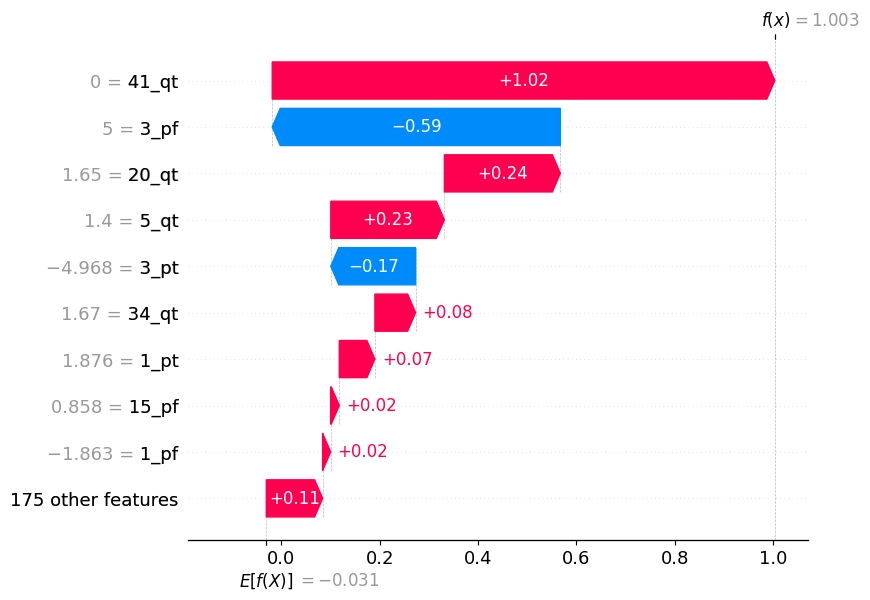

In [4]:
# waterfall plot for local importance
fig=plt.gcf()
shap.plots.waterfall(shap_explainer[1,:], max_display = 10)
#fig.savefig('figures/classification/waterfall_local_1.png', bbox_inches='tight', pad_inches=0.1)

## Global Importance
We can explain the global importance of features, i.e. the importance of all individual features over the entire dataset, in the following summary plot. 

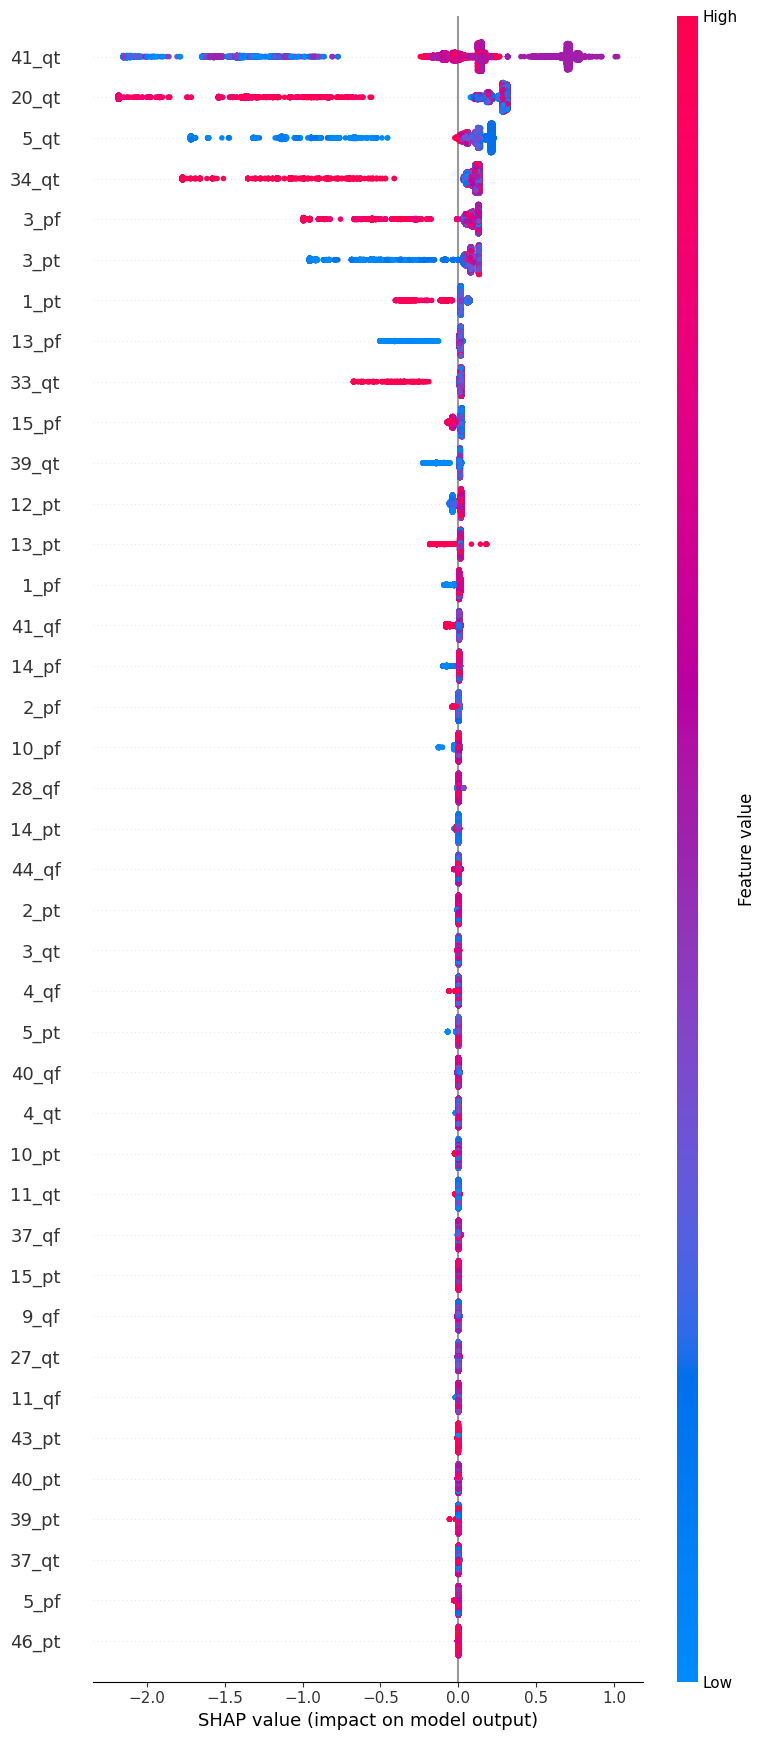

In [5]:
# Summary Plot
fig=plt.gcf()
shap.summary_plot(shap_explainer.values, features, feature_names, max_display = 40)
fig.savefig('figures/classification/beeswarm_global_long.png', bbox_inches='tight', pad_inches=0.1)

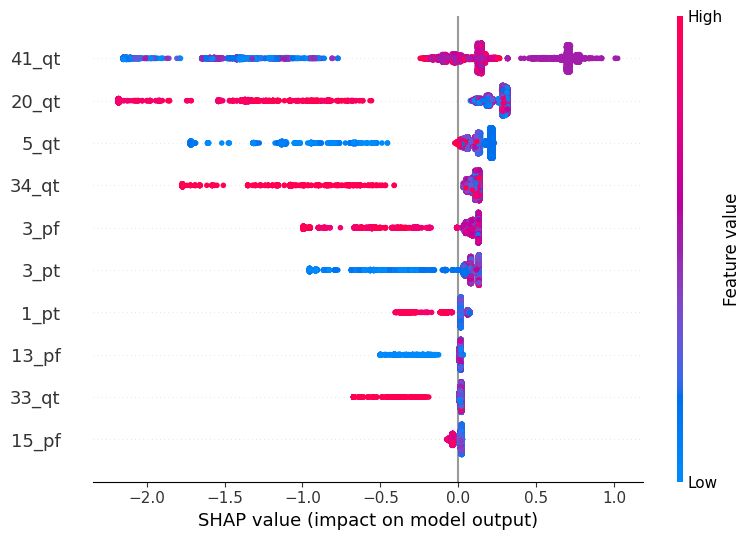

In [6]:
# Summary Plot
fig=plt.gcf()
shap.summary_plot(shap_explainer.values, features, feature_names, max_display = 10)
fig.savefig('figures/classification/beeswarm_global_short.png', bbox_inches='tight', pad_inches=0.1)

In [7]:
# Calculate the mean absolute SHAP value for each feature
mean_shap_values = np.mean(np.abs(shap_explainer.values), axis=0)

# Get the indices of features sorted by mean absolute SHAP values (from highest to lowest)
top_feature_indices = np.argsort(mean_shap_values)[::-1]

# If you want to extract the top N features, you can slice the result
N = 10  # For example, top 10 features
top_N_indices = top_feature_indices[:N]

# Print the indices of the top N features
print("Indices of top N features with the biggest impact:", feature_names[top_N_indices])


Indices of top N features with the biggest impact: Index(['41_qt', '20_qt', '5_qt', '34_qt', '3_pf', '3_pt', '1_pt', '13_pf',
       '33_qt', '15_pf'],
      dtype='object')


In [8]:
# Take only the most important features for your new training set
X_method_red = dataset.X_method.iloc[:, top_N_indices]
X_train_red = dataset.X_train.iloc[:, top_N_indices]
X_test_red = dataset.X_test.iloc[:, top_N_indices]
y_train = dataset.y_train
y_test = dataset.y_test

In [9]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import f1_score, accuracy_score


# Initialize XGBoost model
model = xgb.XGBClassifier(
    objective="binary:logistic",  # objective='multi:softmax' or objective='multi:softprob'
    n_estimators=2000,  
    learning_rate=0.001,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42
)

# Train the XGBoost model
model.fit(
    X_train_red, y_train, 
    eval_set=[(X_train_red, y_train), (X_test_red, y_test)],  # Add validation set
    verbose=250  # Now it will print progress
)

# Make predictions
y_pred = model.predict(X_test_red)

# Compute RMSE
f1 = f1_score(y_test, y_pred, average='macro') # Use average='micro' or 'macro' for multilabel
print(f"Test f1: {f1:.4f}")

fpr_method_red, fnr_method_red, FP_list_method_red, FN_list_method_red = fpr_score(y_test, y_pred)
print(f"False positive rate: {fpr_method_red}")


[0]	validation_0-logloss:0.69244	validation_1-logloss:0.69241
[250]	validation_0-logloss:0.57091	validation_1-logloss:0.57094
[500]	validation_0-logloss:0.48675	validation_1-logloss:0.48695
[750]	validation_0-logloss:0.42528	validation_1-logloss:0.42555
[1000]	validation_0-logloss:0.37920	validation_1-logloss:0.37941
[1250]	validation_0-logloss:0.34367	validation_1-logloss:0.34388
[1500]	validation_0-logloss:0.31547	validation_1-logloss:0.31583
[1750]	validation_0-logloss:0.29236	validation_1-logloss:0.29274
[1999]	validation_0-logloss:0.27341	validation_1-logloss:0.27378
Test f1: 0.9144
False positive rate: 0.16522423288749016


In [10]:
import shap 
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Enable JS visualization
shap.initjs()

# data to explain
features = X_train_red
labels = y_train
feature_names = X_method_red.columns
explainer_type = 'tree'

# Load SHAP TreeExplainer
if explainer_type == 'tree':
    explainer = shap.TreeExplainer(model) 

# Compute SHAP values for the test set 
if explainer_type == 'tree': 
    shap_explainer = explainer(features) # explainer.shap_values(features)


# Print shapes for debugging
print(f"shap values shape: {shap_explainer.shape}")
print(f"features shape: {features.shape}")
print(f"labels shape: {labels.shape}")


shap values shape: (7500, 10)
features shape: (7500, 10)
labels shape: (7500,)


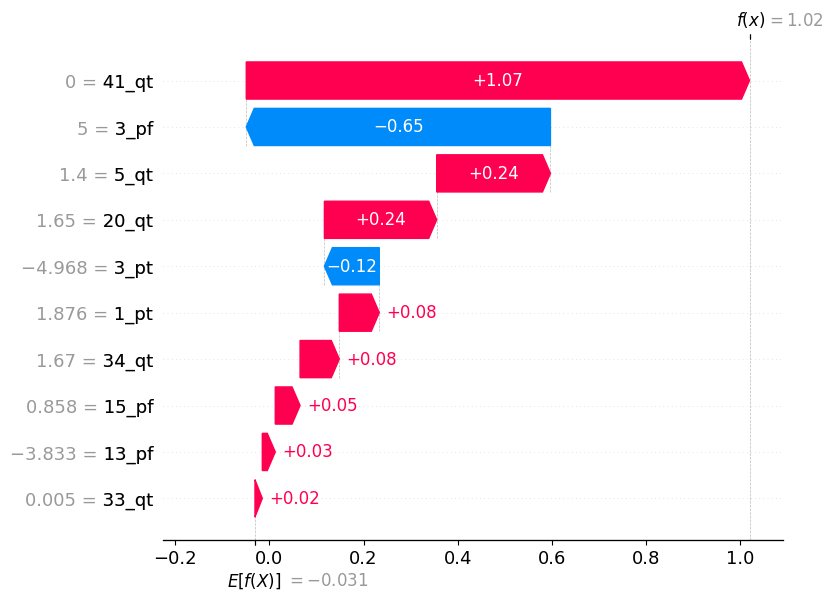

In [11]:
# waterfall plot for local importance
fig=plt.gcf()
shap.plots.waterfall(shap_explainer[1,:], max_display = 10)
#fig.savefig('figures/classification/waterfall_local_1.png', bbox_inches='tight', pad_inches=0.1)

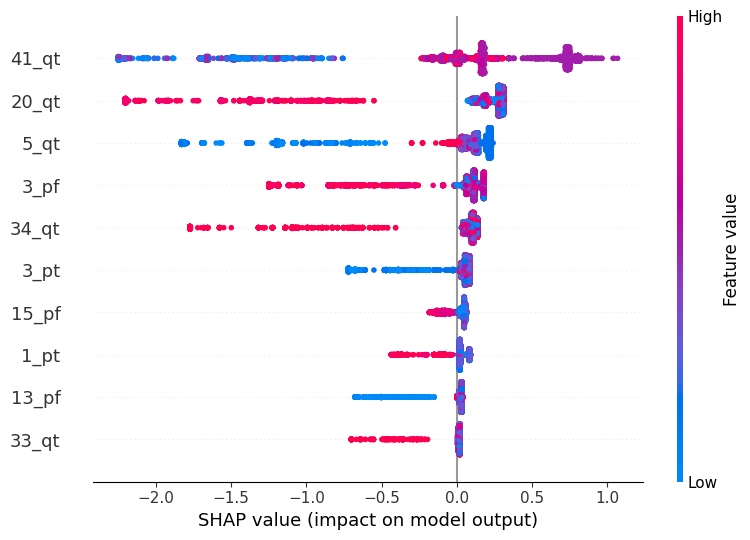

In [12]:
# Summary Plot
fig=plt.gcf()
shap.summary_plot(shap_explainer.values, features, feature_names)
fig.savefig('figures/classification/beeswarm_global_red.png', bbox_inches='tight', pad_inches=0.1)

## Explaining False Positives

For classification of operating points, missclassifying an operating points as secure, even though it's not secure (i.e. false positive) is very bad. Now with SHAP, we can analyze why the point is missclassified, and potentially use this information to improve our classifier. 

In [13]:
op_data_method_unmod = dataset.op_data_method_unmod
flow_path_method = dataset.flow_path_method

#Explain False positives
fp_method_ops = op_data_method_unmod.iloc[FP_list_method_red]

data_fp_method = pd.read_csv(flow_path_method, sep = ';')
data_fp_method = data_fp_method.iloc[FP_list_method_red]

X_fp_method = data_fp_method.drop(columns = ['feasible', 'stable'], axis=1) 
y_fp_method = ((data_fp_method['stable'] == 1) & (data_fp_method['feasible'] == 1)).astype(int)
features = X_fp_method.iloc[:, top_N_indices]

# Compute SHAP values for the test set 
shap_fp_explainer = explainer(features) # explainer.shap_values(features)

# Explain a single missclassified point

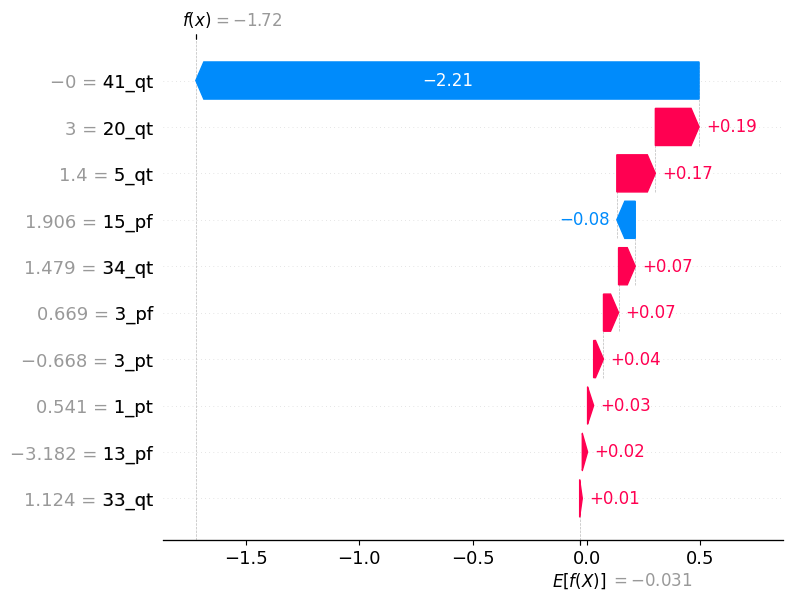

In [14]:
# waterfall plot for local importance
fig=plt.gcf()
shap.plots.waterfall(shap_fp_explainer[0,:], max_display = 10)
#fig.savefig('figures/classification/waterfall_fp_local_1.png', bbox_inches='tight', pad_inches=0.1)

## Explain all missclassified points

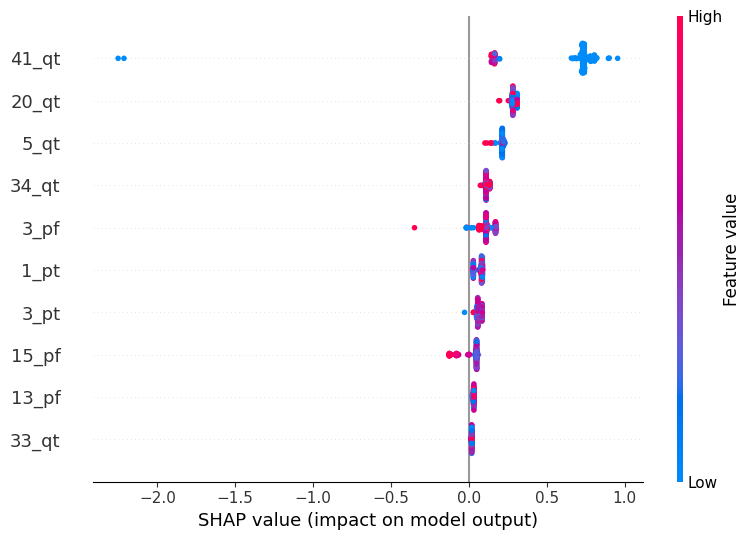

In [15]:
# Summary Plot
fig=plt.gcf()
shap.summary_plot(shap_fp_explainer.values, features, feature_names)
#fig.savefig('figures/classification/beeswarm_fp_global.png', bbox_inches='tight', pad_inches=0.1)